In [1]:
## Install Dependencies
!pip install pandas numpy matplotlib easydict tqdm celluloid torch ipywidgets kaggle

In [ ]:
!kaggle datasets download -d nphantawee/pump-sensor-data

In [5]:
## Import Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import easydict
import pickle
from typing import List
from tqdm.notebook import trange, tqdm
from celluloid import Camera

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## Exploratory Data Analysis

In [6]:
## 데이터 불러오기
df = pd.read_csv('./dataset/sensor.csv', index_col=0)
## 데이터 확인
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [7]:
def plot_sensor(temp_df, save_path='sample.gif'):
    fig = plt.figure(figsize=(16, 6))
    ## 에니메이션 만들기
    camera = Camera(fig)
    ax=fig.add_subplot(111)
    
    ## 불량 구간 탐색 데이터
    labels = temp_df['machine_status'].values.tolist()
    dates = temp_df.index
    
    for var_name in tqdm([item for item in temp_df.columns if 'sensor_' in item]):
        ## 센서별로 사진 찍기
        temp_df[var_name].plot(ax=ax)
        ax.legend([var_name], loc='upper right')
        
        ## 고장구간 표시
        temp_start = dates[0]
        temp_date = dates[0]
        temp_label = labels[0]
        
        for xc, value in zip(dates, labels):
            if temp_label != value:
                if temp_label == "BROKEN":
                    ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
                if temp_label == "RECOVERING":
                    ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
                temp_start=xc
                temp_label=value
            temp_date = xc
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, xc, alpha=0.2, color='orange')
        ## 카메라 찍기
        camera.snap()
        
    animation = camera.animate(500, blit=True)
    # .gif 파일로 저장하면 끝!
    animation.save(
        save_path
    )

  0%|          | 0/52 [00:00<?, ?it/s]

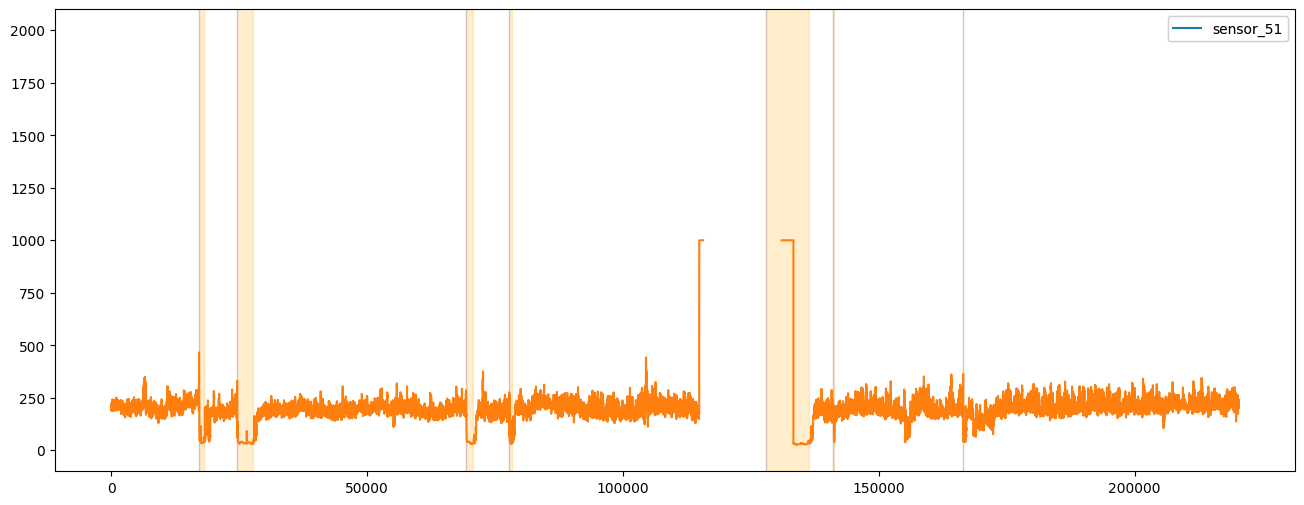

In [8]:
plot_sensor(df)

## Data Preprocessing

In [9]:
## change data type
df['date'] = pd.to_datetime(df['timestamp'])
for var_index in [item for item in df.columns if 'sensor_' in item]:
    df[var_index] = pd.to_numeric(df[var_index], errors='coerce')
del df['timestamp']

## change date column to index of dataframe
df = df.set_index('date')

<AxesSubplot: >

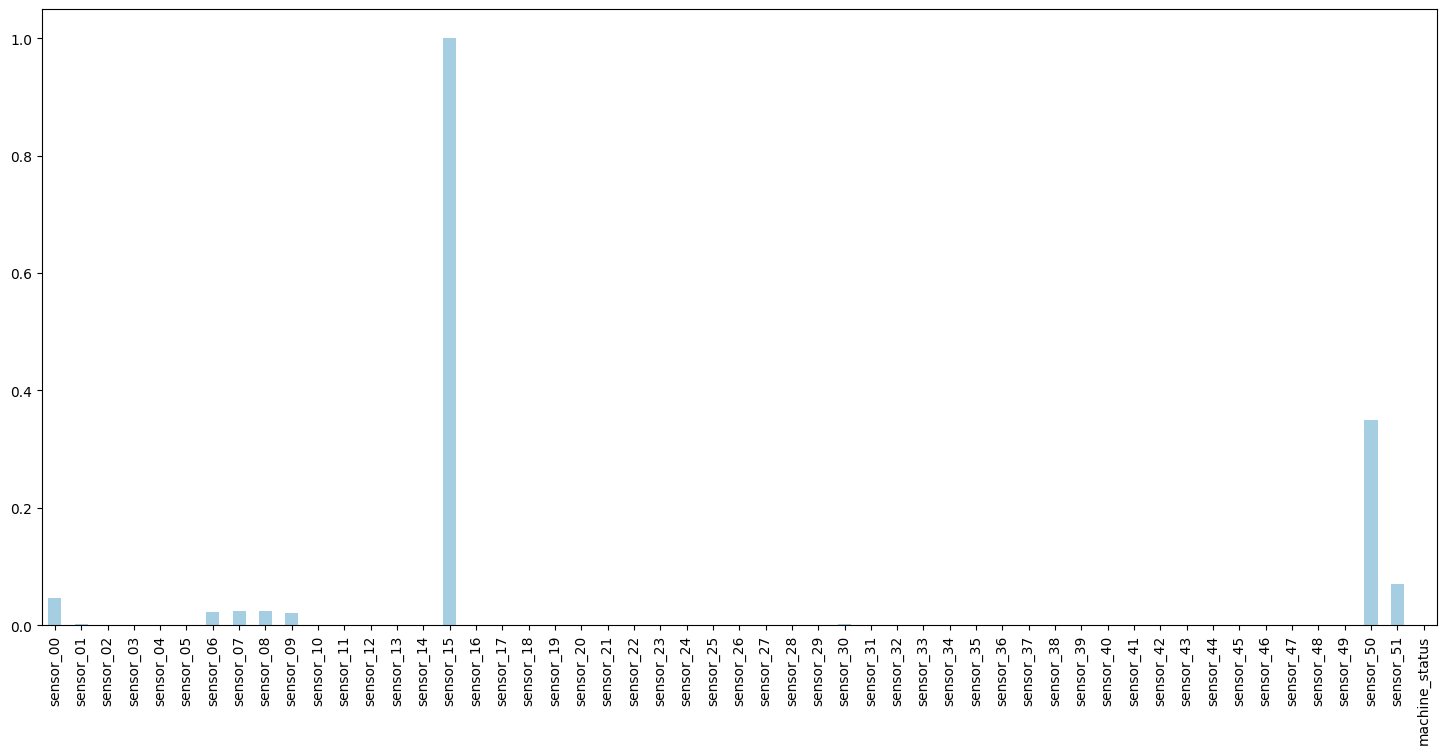

In [10]:
##  check out missing value
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')

#### 'sensor_15'column has a lot of missing values...
#### Missing values can make a big effect to performance of the model, even if there have been made tons of effort.
### So, we decide to erase 'sensor_15' and 'sensor_50'

In [11]:
## Erase duplicated data
df = df.drop_duplicates()

## delete sensor_15 and sensor_50
del df['sensor_15']
del df['sensor_50']

## interpolate data with data on the right before the point.
df= df.fillna(method='ffill')

## data split and normalize

In [12]:
normal_df = df[df['machine_status']=='NORMAL']
abnormal_df = df[df['machine_status']!='NORMAL']

In [13]:
## Data is time-series data, which is sequences of a specific window size.
## So we don't use shuffle to shuffle the data.
## We're gonna split 'Normal' data into 70% for training, 10% for setting parameter, 10% for validation, and the other for testing.

interval_n = int(len(normal_df)/10)
normal_df1 = df.iloc[0:interval_n*7]
normal_df2 = df.iloc[interval_n*7:interval_n*8]
normal_df3 = df.iloc[interval_n*8:interval_n*9]
normal_df4 = df.iloc[interval_n*9:]

## Using a half of 'Abnormal'data as validation, and the other for testing.
interval_ab = int(len(abnormal_df)/2)
abnormal_df1 = df.iloc[0:interval_ab]
abnormal_df2 = df.iloc[interval_ab:]

In [14]:
## for data normalization(standardization)
mean_df = normal_df1.iloc[:, :50].mean()
std_df = normal_df1.iloc[:, :50].std()

## Why? we're doing normalizing data?
## If each sensor data(feature) has the very different range of degrees, it is possible for the model to be dependent to some features which have the biggest degrees.
## To avoid the dependence problem, we use data normalization.

## Setting Data Structure for training

In [15]:
def make_data_idx(dates, window_size=1):
    input_idx = []
    for idx in range(window_size-1, len(dates)):
        cur_date = dates[idx].to_pydatetime()
        in_date = dates[idx - (window_size-1)].to_pydatetime()
        
        _in_period = (cur_date - in_date).days * 24 * 60 + (cur_date - in_date).seconds / 60
        
        ## check indexes hava a minute gap each other.
        if _in_period == (window_size-1):
            input_idx.append(list(range(idx - window_size+1, idx+1)))
    return input_idx

In [16]:
## inherit Dataset of PyTorch and setting dataset
class TagDataset(Dataset):
    def __init__(self, input_size, df, mean_df=None, std_df = None, window_size=1):
        
        ## the number of feature
        self.input_size = input_size
        
        ## length of sequence to restore
        self.window_size = window_size
        
        ## Deep copy Summary data
        original_df = df.copy()
        
        ## normalization
        if mean_df is not None and std_df is not None:
            sensor_columns = [item for item in df.columns if 'sensor_' in item]
            df[sensor_columns] = (df[sensor_columns]-mean_df)/std_df
        
        dates = list(df.index)
        self.input_ids = make_data_idx(dates, window_size=window_size)
        
        ## use sensor data for reconstruct
        self.selected_column = [item for item in df.columns if 'sensor_' in item][:input_size]
        self.var_data = torch.tensor(df[self.selected_column].values, dtype=torch.float)
        
        ## Summary
        self.df = original_df.iloc[np.array(self.input_ids)[:, -1]]
        
    ## Dataset of PyTorch should have __len__ function(length of dataset)
    def __len__(self):
        return len(self.input_ids)
    
    ## Dataset of PyTorch should have __getitem__
    ## torch module calls __getitem__ to load training data
    def __getitem__(self, item):
        temp_input_ids = self.input_ids[item]
        input_values = self.var_data[temp_input_ids]
        return input_values

## Setting model

In [17]:
## Encopder
class Encoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        return (hidden, cell)  

In [18]:
## Decoder
class Decoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)  ## Final layer: fully connected layer
        
    def forward(self, x, hidden):
        output, (hidden, cell) = self.lstm(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        prediction = self.fc(output)
        return prediction, (hidden, cell)

In [19]:
## LSTM Auto Encoder
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 window_size: int=1,
                 **kwargs) -> None:
        """
        :param input_dim: 변수 Tag 갯수
        :param latent_dim: 최종 압축할 차원 크기
        :param window_size: 길이
        :param kwargs:
        """

        super(LSTMAutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.window_size = window_size

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1

        self.encoder = Encoder(
            input_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_dim,
            output_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )

    def forward(self, src:torch.Tensor, **kwargs):
        batch_size, sequence_length, var_length = src.size()

        ## Encoder 넣기
        encoder_hidden = self.encoder(src)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, src]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        
        ## MSE loss(Mean squared Error)
        loss =F.mse_loss(recons, input)
        return loss

## Training

In [20]:
def run(args, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## iteration
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## training
    count = 0
    best_loss = 100000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            loss = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                
                batch_data = batch_data.to(args.device)
                predict_values = model(batch_data)
                loss = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        if eval_loss < best_loss:
            best_loss = eval_loss
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

In [21]:
def get_loss_list(args, model, test_loader):
    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
    loss_list = []
    
    with torch.no_grad():
        for i, batch_data in test_iterator:
                
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
        
            ## Calculate MAE(Mean Absolute Error)
            loss = F.l1_loss(predict_values[0], predict_values[1], reduce=False)
            #loss = loss.sum(dim=2).sum(dim=1).cpu().numpy()
            loss = loss.mean(dim=1).cpu().numpy()
            loss_list.append(loss)
    loss_list = np.concatenate(loss_list, axis=0)
    return loss_list

## Setting model and hyperparameter for training

In [22]:
args = easydict.EasyDict({
    "batch_size": 64, ## batch_size
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU utility
    "input_size": 40, ## input dimension
    "latent_size": 10, ## Hidden layer dimension
    "output_size": 40, ## output dimention
    "window_size" : 3, ## sequence Length
    "num_layers": 2,     ## number of LSTM layer
    "learning_rate" : 0.001, ## learning rate
    "max_iter" : 100000, ## Iteration
    'early_stop' : True,  ## early stop
})

## Train!

In [23]:
## Convert datainto Dataset of PyTorch!
normal_dataset1 = TagDataset(df=normal_df1, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset2 = TagDataset(df=normal_df2, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset3 = TagDataset(df=normal_df3, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
normal_dataset4 = TagDataset(df=normal_df4, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
abnormal_dataset1 = TagDataset(df=abnormal_df1, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
abnormal_dataset2 = TagDataset(df=abnormal_df2, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)

C:\Users\vaiv\AppData\Local\Temp\ipykernel_34744\4120193331.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_columns] = (df[sensor_columns]-mean_df)/std_df
C:\Users\vaiv\AppData\Local\Temp\ipykernel_34744\4120193331.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_columns] = (df[sensor_columns]-mean_df)/std_df
C:\Users\vaiv\AppData\Local\Temp\ipykernel_34744\4120193331.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [24]:
## Dataset to Data Loader
train_loader = torch.utils.data.DataLoader(dataset=normal_dataset1,
                 batch_size=args.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=normal_dataset2,
                batch_size=args.batch_size, shuffle=False)

In [25]:
## Modelling
model = LSTMAutoEncoder(input_dim=args.input_size, latent_dim=args.latent_size, window_size=args.window_size, num_layers=args.num_layers)
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(40, 10, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(40, 10, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=10, out_features=40, bias=True)
  )
)

In [26]:
model = run(args, model, train_loader, valid_loader)

  0%|          | 0/47 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

training:   0%|          | 0/2173 [00:00<?, ?it/s]

testing:   0%|          | 0/307 [00:00<?, ?it/s]

early stop condition   best_loss[0.09806994590240892]  eval_loss[0.09904011385060289]


## measure anomaly score

In [27]:
## Reconstruction Error
loss_list = get_loss_list(args, model, valid_loader)

## Calculate mean of Reconstruction Error and Covarinace
mean = np.mean(loss_list, axis=0)
std = np.cov(loss_list.T)

testing:   0%|          | 0/307 [00:00<?, ?it/s]

C:\Users\vaiv\Documents\blog\lstm_autoencoder_torch\.lstm_ae_torch__\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [28]:
## Anomaly Score
class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        assert mean.shape[0] == std.shape[0] and mean.shape[0] == std.shape[1], '평균과 분산의 차원이 똑같아야 합니다.'
        self.mean = mean
        self.std = std
    
    def __call__(self, recons_error:np.array):
        x = (recons_error-self.mean)
        return np.matmul(np.matmul(x, self.std), x.T)

anomaly_calculator = Anomaly_Calculator(mean, std)

In [29]:
## Threshold 찾기
anomaly_scores = []
for temp_loss in tqdm(loss_list):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

## 정상구간에서 비정상 점수 분포
print("평균[{}], 중간[{}], 최소[{}], 최대[{}]".format(np.mean(anomaly_scores), np.median(anomaly_scores), np.min(anomaly_scores), np.max(anomaly_scores)))

  0%|          | 0/19620 [00:00<?, ?it/s]

평균[0.08248594180853762], 중간[0.04421350959668712], 최소[0.005779459524162748], 최대[4.278522233261983]


## Visualize all data

In [30]:
## 전체 데이터 불러오기
total_dataset = TagDataset(df=df, input_size=args.input_size, window_size=args.window_size, mean_df=mean_df, std_df=std_df)
total_dataloader = torch.utils.data.DataLoader(dataset=total_dataset,batch_size=args.batch_size,shuffle=False)

## Reconstruction Loss를 계산하기
total_loss = get_loss_list(args, model, total_dataloader)

## 이상치 점수 계산하기
anomaly_scores = []
for temp_loss in tqdm(total_loss):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

visualization_df = total_dataset.df
visualization_df['score'] = anomaly_scores
visualization_df['recons_error'] = total_loss.sum(axis=1)

testing:   0%|          | 0/3309 [00:00<?, ?it/s]

C:\Users\vaiv\Documents\blog\lstm_autoencoder_torch\.lstm_ae_torch__\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/211715 [00:00<?, ?it/s]

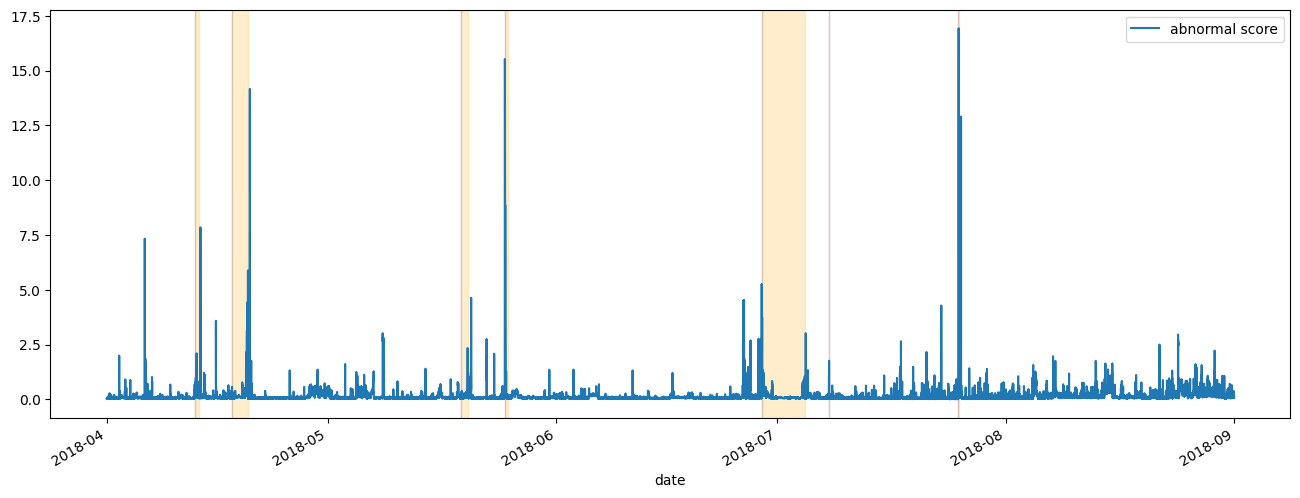

In [31]:
## 시각화 하기
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot(111)

## 불량 구간 탐색 데이터
labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index


visualization_df['score'].plot(ax=ax)
ax.legend(['abnormal score'], loc='upper right')

## 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha=0.2, color='orange')

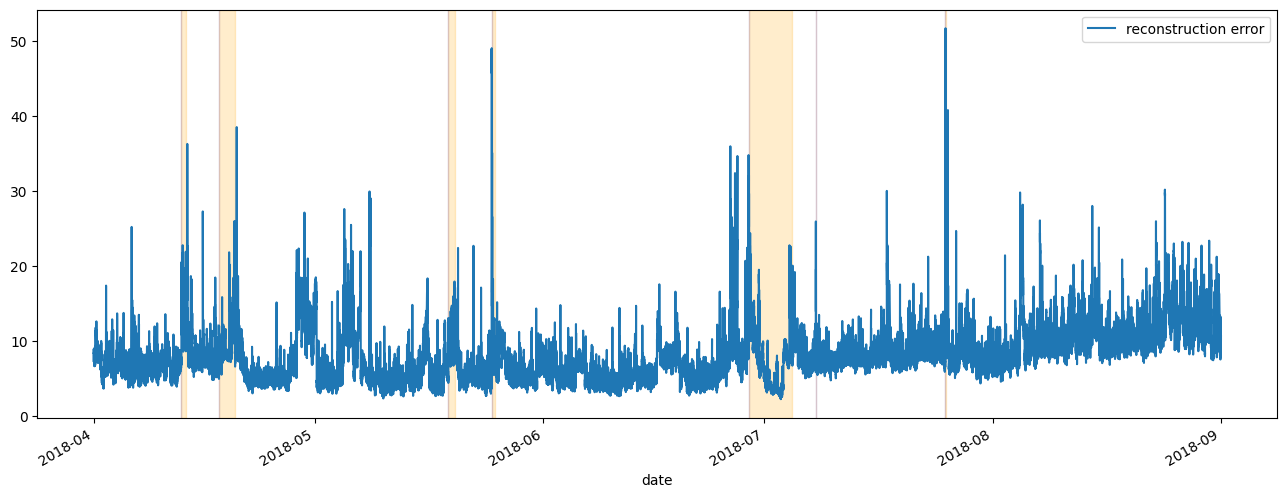

In [32]:
## 시각화 하기
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot(111)

## 불량 구간 탐색 데이터
labels = visualization_df['machine_status'].values.tolist()
dates = visualization_df.index


visualization_df['recons_error'].plot(ax=ax)
ax.legend(['reconstruction error'], loc='upper right')

## 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='blue')
        if temp_label == "RECOVERING":
            ax.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    ax.axvspan(temp_start, xc, alpha=0.2, color='blue')
if temp_label == "RECOVERING":
    ax.axvspan(temp_start, xc, alpha=0.2, color='orange')